# Running inference tools

As machine learning (ML) becomes more popular in HEP analysis, `coffea` also
provide tools to assist with using ML tools within the coffea framework. For
training and validation, you would likely need custom data mangling tools to
convert HEP data formats ([NanoAOD][nanoaod], [PFNano][pfnano]) to a format that
best interfaces with the ML tool of choice, as for training and validation, you
typical want to have fine control over what computation is done. For more
advanced use cases of data mangling and data saving, refer to the [awkward array
manual][datamangle] and [uproot][uproot_write]/[parquet][ak_parquet] write
operations for saving intermediate states. The helper tools provided in coffea
focuses on ML inference, where ML tool outputs are used as another variable to
be used in the event/object selection chain.

[nanoaod]: https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookNanoAOD
[pfnano]: https://github.com/cms-jet/PFNano
[datamangle]: https://awkward-array.org/doc/main/user-guide/how-to-restructure.html
[uproot_write]: https://uproot.readthedocs.io/en/latest/basic.html#writing-ttrees-to-a-file
[ak_parquet]: https://awkward-array.org/doc/main/reference/generated/ak.to_parquet.html


## Why these wrapper tools are needed

The typical operation of using ML inference tools in the awkward/coffea analysis
tools involves the conversion and padding of awkward array to ML tool containers
(usually something that is `numpy`-compatible), run the inference, then
convert-and-truncate back into the awkward array syntax required for the
analysis chain to continue. With awkward arrays' laziness now being handled
entirely by [`dask`][dask_awkward], the conversion operation of awkward array to
other array types needs to be wrapped in a way that is understandable to `dask`.
The packages in the `ml_tools` package attempts to wrap the common tools used by
the HEP community with a common interface to reduce the verbosity of the code on
the analysis side.

[dask_awkward]: https://dask-awkward.readthedocs.io/en/stable/gs-limitations.html


## Example using ParticleNet-like jet variable calculation using PyTorch

The example given in this notebook be using [`pytorch`][pytorch] to calculate a
jet-level discriminant using its constituent particles. An example for how to
construct such a `pytorch` network can be found in the docs file, but for
`mltools` in coffea, we only support the [TorchScript][pytorch] format files to
load models to ensure operability when scaling to clusters. Let us first start
by downloading the example ParticleNet model file and a small `PFNano`
compatible file, and a simple function to open the `PFNano` with and without
dask.

[pytorch]: https://pytorch.org/
[pytorch_jit]: https://pytorch.org/tutorials/beginner/saving_loading_models.html#export-load-model-in-torchscript-format


In [1]:
!wget --quiet -O model.pt https://github.com/CoffeaTeam/coffea/raw/ml_tools/tests/samples/triton_models_test/pn_test/1/model.pt
!wget --quiet -O pfnano.root https://github.com/CoffeaTeam/coffea/raw/ml_tools/tests/samples/pfnano.root


In [2]:
from coffea.nanoevents import NanoEventsFactory
from coffea.nanoevents.schemas import PFNanoAODSchema


def open_events(permit_dask=False):
    factory = NanoEventsFactory.from_root(
        "file:./pfnano.root",
        schemaclass=PFNanoAODSchema,
        permit_dask=permit_dask,
    )
    return factory.events()


Now we prepare a class to handle inference request by extending the
`mltools.torch_wrapper` class. As the base class cannot know anything about the
data mangling required for the users particular model, we will need to overload
at least the method `prepare_awkward`:

- The input can be an arbitrary number of awkward arrays or dask awkward array
  (but never a mix of dask/non-dask array). In this example, we will be passing
  in the event array.
- The output should be single tuple `a` + single dictionary `b`, this is to
  ensure that arbitrarily complicated outputs can be passed to the underlying
  `pytorch` model instance like `model(*a, **b)`. The contents of `a` and `b`
  should be `numpy`-compatible awkward-like arrays: if the inputs are non-dask
  awkward arrays, the return should also be non-dask awkward arrays that can be
  trivially converted to `numpy` arrays via a `ak.to_numpy` call; if the inputs
  are dask awkward arrays, the return should be still be dask awkward arrays
  that can be trivially converted via a `to_awkward().to_numpy()` call. To
  minimize changes to the code, a simple `dask_awkward/awkward` switcher
  `get_awkward_lib` is provided, as there should be (near)-perfect feature
  parity between the dask and non-dask arrays.

  In this ParticleNet-like example, the model expects the following inputs:

  - A `N` jets x `2` coordinate x `100` constituents "points" array,
    representing the constituent coordinates.
  - A `N` jets x `5` feature x `100` constituents "features" array, representing
    the constituent features of interest to be used for inference.
  - A `N` jets x `1` mask x `100` constituent "mask" array, representing whether
    a constituent should be masked from the inference request.

  In this case, we will need to flatten the `E` events x `N` jets structure,
  then, we will need to stack the constituent attributes of interest via
  `ak.concatenate` into a single array.

After defining this minimum class, we can attempt to run inference using the
`__call__` method defined in the base class. Notice that overloading this single
method will automatically allow for the inference to be called on both awkward
and dask-awkward.


In [3]:
from coffea.ml_tools.torch_wrapper import torch_wrapper
import awkward
import dask_awkward
import numpy as np


class ParticleNetExample1(torch_wrapper):
    def prepare_awkward(self, events):
        ak = self.get_awkward_lib(events)
        jets = ak.flatten(events.Jet)

        def pad(arr):
            return ak.fill_none(
                ak.pad_none(arr, 100, axis=1, clip=True),
                0.0,
            )

        # Human readable version of what the inputs are
        # Each array is a N jets x 100 constituent array
        imap = {
            "points": {
                "deta": pad(jets.eta - jets.constituents.pf.eta),
                "dphi": pad(jets.delta_phi(jets.constituents.pf)),
            },
            "features": {
                "dr": pad(jets.delta_r(jets.constituents.pf)),
                "lpt": pad(np.log(jets.constituents.pf.pt)),
                "lptf": pad(np.log(jets.constituents.pf.pt / jets.pt)),
                "f1": pad(np.log(np.abs(jets.constituents.pf.d0) + 1)),
                "f2": pad(np.log(np.abs(jets.constituents.pf.dz) + 1)),
            },
            "mask": {
                "mask": pad(ak.ones_like(jets.constituents.pf.pt)),
            },
        }

        # Compacting the array elements into the desired dimension using
        # ak.concatenate
        retmap = {
            k: ak.concatenate([x[:, np.newaxis, :] for x in imap[k].values()], axis=1)
            for k in imap.keys()
        }

        # Returning everything using a dictionary. Also perform type conversion!
        return (), {
            "points": ak.values_astype(retmap["points"], "float32"),
            "features": ak.values_astype(retmap["features"], "float32"),
            "mask": ak.values_astype(retmap["mask"], "float16"),
        }


# Setting up the model container
pn_example1 = ParticleNetExample1("model.pt")

# Running on awkward arrays
ak_events = open_events(permit_dask=False)
ak_results = pn_example1(ak_events)
print("Awkward results:", ak_results)  # Runs fine!

# Running on dask_awkward array
dask_events = open_events(permit_dask=True)
dask_results = pn_example1(dask_events)
print("Dask awkward results:", dask_results)  # Also runs file!

# Checking that the results are identical
assert awkward.all(dask_results.compute() == ak_results)


/home/ensc/VirtualENV/coffea-test/lib/python3.8/site-packages/coffea/ml_tools/helper.py:163: UserWarning: No format checks were performed on input!
  warnings.warn("No format checks were performed on input!")


Awkward results: [[0.0693, -0.0448], [0.0678, -0.0451], ..., [0.0616, ...], [0.0587, -0.0172]]
Dask awkward results: dask.awkward<numpy_call_ParticleNetExample1_143880bd51265ab5cb0ff3b61a1522c0, npartitions=1>


For each jet in the input to the `torch` model, the model returns a 2-tuple
probability value. Without additional specification, the `torch_wrapper` class
performs a trival conversion of `ak.from_numpy` of the torch model's output. We
can specify that we want to fold this back into nested structure by overloading
the `postprocess_awkward` method of the class.

For the ParticleNet example we are going perform additional computation for the
conversion back to awkward array formats:

- Calculate the `softmax` method for the return of each jet (commonly used as
  the singular ML inference "scores")
- Fold the computed `softmax` array back into nested structure that is
  compatible with the original events.Jet array.

Notice that the inputs of the `postprocess_awkward` method is different from the
`prepare_awkward` method, only by that the first argument is the return array
of the model inference after the trivial `from_numpy` conversion. Notice that
the return_array can be dask arrays, so the awkward/dask-awkward switching
function should also be used in this method.


In [4]:
class ParticleNetExample2(ParticleNetExample1):
    def postprocess_awkward(self, return_array, events):
        ak = self.get_awkward_lib(return_array)
        softmax = np.exp(return_array)[:, 0] / ak.sum(np.exp(return_array), axis=-1)
        njets = ak.count(events.Jet.pt, axis=-1)
        return ak.unflatten(softmax, njets)


pn_example2 = ParticleNetExample2("model.pt")

# Running on awkward
ak_events = open_events(permit_dask=False)
ak_jets = ak_events.Jet
ak_jets["MLresults"] = pn_example2(ak_events)
ak_events["Jet"] = ak_jets
print(ak_events.Jet.MLresults)

# Running on dask awkward
dask_events = open_events(permit_dask=True)
dask_jets = dask_events.Jet
dask_jets["MLresults"] = pn_example2(dask_events)
dask_events["Jet"] = dask_jets
print(dask_events.Jet.MLresults)

assert awkward.all(ak_events.Jet.MLresults == dask_events.Jet.MLresults.compute())


[[0.528, 0.528, 0.524, 0.523, 0.521, 0.52, 0.519, 0.519], ..., [0.528, ...]]


/home/ensc/VirtualENV/coffea-test/lib/python3.8/site-packages/dask_awkward/lib/structure.py:751: UserWarning: Please ensure that dask.awkward<count, npartitions=1>
        is partitionwise-compatible with dask.awkward<divide, npartitions=1>
        (e.g. counts comes from a dak.num(array, axis=1)),
        otherwise this unflatten operation will fail when computed!
  warnings.warn(


dask.awkward<MLresults, npartitions=1>


Of course, the implementation of the classes above can be written in a single
class. Here is a copy-and-paste implementation of the class with all the
functionality described in the cells above:


In [5]:
class ParticleNetExample(torch_wrapper):
    def prepare_awkward(self, events):
        ak = self.get_awkward_lib(events)
        jets = ak.flatten(events.Jet)

        def pad(arr):
            return ak.fill_none(
                ak.pad_none(arr, 100, axis=1, clip=True),
                0.0,
            )

        # Human readable version of what the inputs are
        # Each array is a N jets x 100 constituent array
        imap = {
            "points": {
                "deta": pad(jets.eta - jets.constituents.pf.eta),
                "dphi": pad(jets.delta_phi(jets.constituents.pf)),
            },
            "features": {
                "dr": pad(jets.delta_r(jets.constituents.pf)),
                "lpt": pad(np.log(jets.constituents.pf.pt)),
                "lptf": pad(np.log(jets.constituents.pf.pt / jets.pt)),
                "f1": pad(np.log(np.abs(jets.constituents.pf.d0) + 1)),
                "f2": pad(np.log(np.abs(jets.constituents.pf.dz) + 1)),
            },
            "mask": {
                "mask": pad(ak.ones_like(jets.constituents.pf.pt)),
            },
        }

        # Compacting the array elements into the desired dimension using
        # ak.concatenate
        retmap = {
            k: ak.concatenate([x[:, np.newaxis, :] for x in imap[k].values()], axis=1)
            for k in imap.keys()
        }

        # Returning everything using a dictionary. Also take care of type
        # conversion here.
        return (), {
            "points": ak.values_astype(retmap["points"], "float32"),
            "features": ak.values_astype(retmap["features"], "float32"),
            "mask": ak.values_astype(retmap["mask"], "float16"),
        }

    def postprocess_awkward(self, return_array, events):
        ak = self.get_awkward_lib(return_array, events)
        softmax = np.exp(return_array)[:, 0] / ak.sum(np.exp(return_array), axis=-1)
        njets = ak.count(events.Jet.pt, axis=-1)
        return ak.unflatten(softmax, njets)


pn_example = ParticleNetExample("model.pt")

# Running on awkward arrays
ak_events = open_events(permit_dask=False)
ak_jets = ak_events.Jet
ak_jets["MLresults"] = pn_example(ak_events)
ak_events["Jet"] = ak_jets
print(ak_events.Jet.MLresults)

# Running on dask awkward arrays
dask_events = open_events(permit_dask=True)
dask_jets = dask_events.Jet
dask_jets["MLresults"] = pn_example(dask_events)
dask_events["Jet"] = dask_jets
print(dask_events.Jet.MLresults)
# Checking that we get identical results
assert awkward.all(dask_events.Jet.MLresults.compute() == ak_events.Jet.MLresults)
print(dask_awkward.necessary_columns(dask_events.Jet.MLresults))


[[0.528, 0.528, 0.524, 0.523, 0.521, 0.52, 0.519, 0.519], ..., [0.528, ...]]
dask.awkward<MLresults, npartitions=1>
{'from-uproot-9ff71c2b6c06eb15f091c3e41ead5497': ['Jet.pt', 'PFCands.d0', 'JetPFCands.pFCandsIdxG', 'PFCands.phi', 'Jet.phi', 'Jet.eta', 'PFCands.eta', 'PFCands.pt', 'Jet.pFCandsIdxG', 'PFCands.dz']}


In particular, analyzers should check that the last line contains only the
branches required for ML inference; if there are many non-required branches,
this may lead the significant performance penalties. 

As per other dask tools, the users can extract how dask is analyzing the
processing the computation routines using the following snippet.

HighLevelGraph with 103 layers.
 0. from-uproot-40ed9ba7c4cc45e94105e61283f124a3
 1. JetPFCands-f14e9b07eb3c690873f7ea00af7ee8eb
 2. PFCands-d4a8642b8c01c731c7d43e4bde63dba7
 3. JetPFCands-6271438633eb0569493e2a65beb35cb1
 4. PFCands-988dd86d5d366180aedd789b9fd97788
 5. JetPFCands-b9487676f464447b15804d03bca317da
 6. PFCands-915a7a9dd26d7fb2110a52bc38fae16a
 7. JetPFCands-1535528183c6524bb8872d941e3a2320
 8. PFCands-a4e509a69376ee57025fb7c7bfbf7903
 9. JetPFCands-0e8588a67ca85b26e05c720442904a9d
 10. PFCands-e95bd3adde3a14965f38e941f6b912c3
 11. JetPFCands-f14ebf216a7d1a1761a234ad85c21a54
 12. PFCands-18e5d62f1b50a1c0edafa1f39ebe765d
 13. JetPFCands-6beb51836e39d136853699523596bf0e
 14. PFCands-27deeb09b87b1ac27f7199f705a0b003
 15. JetPFCands-8da6714502a3b61dd64f44221e6d0299
 16. PFCands-7e6e94c83dcffeb122571204de8d1392
 17. Jet-fa3ab6fd9c4726ec37bac08fbeed78c9
 18. flatten-4b26fe19858d9257a26a602aef991da8
 19. pFCandsIdxG-e6ffb60d1c3a5132916c6e67aa728476
 20. _apply_global_index-deae4

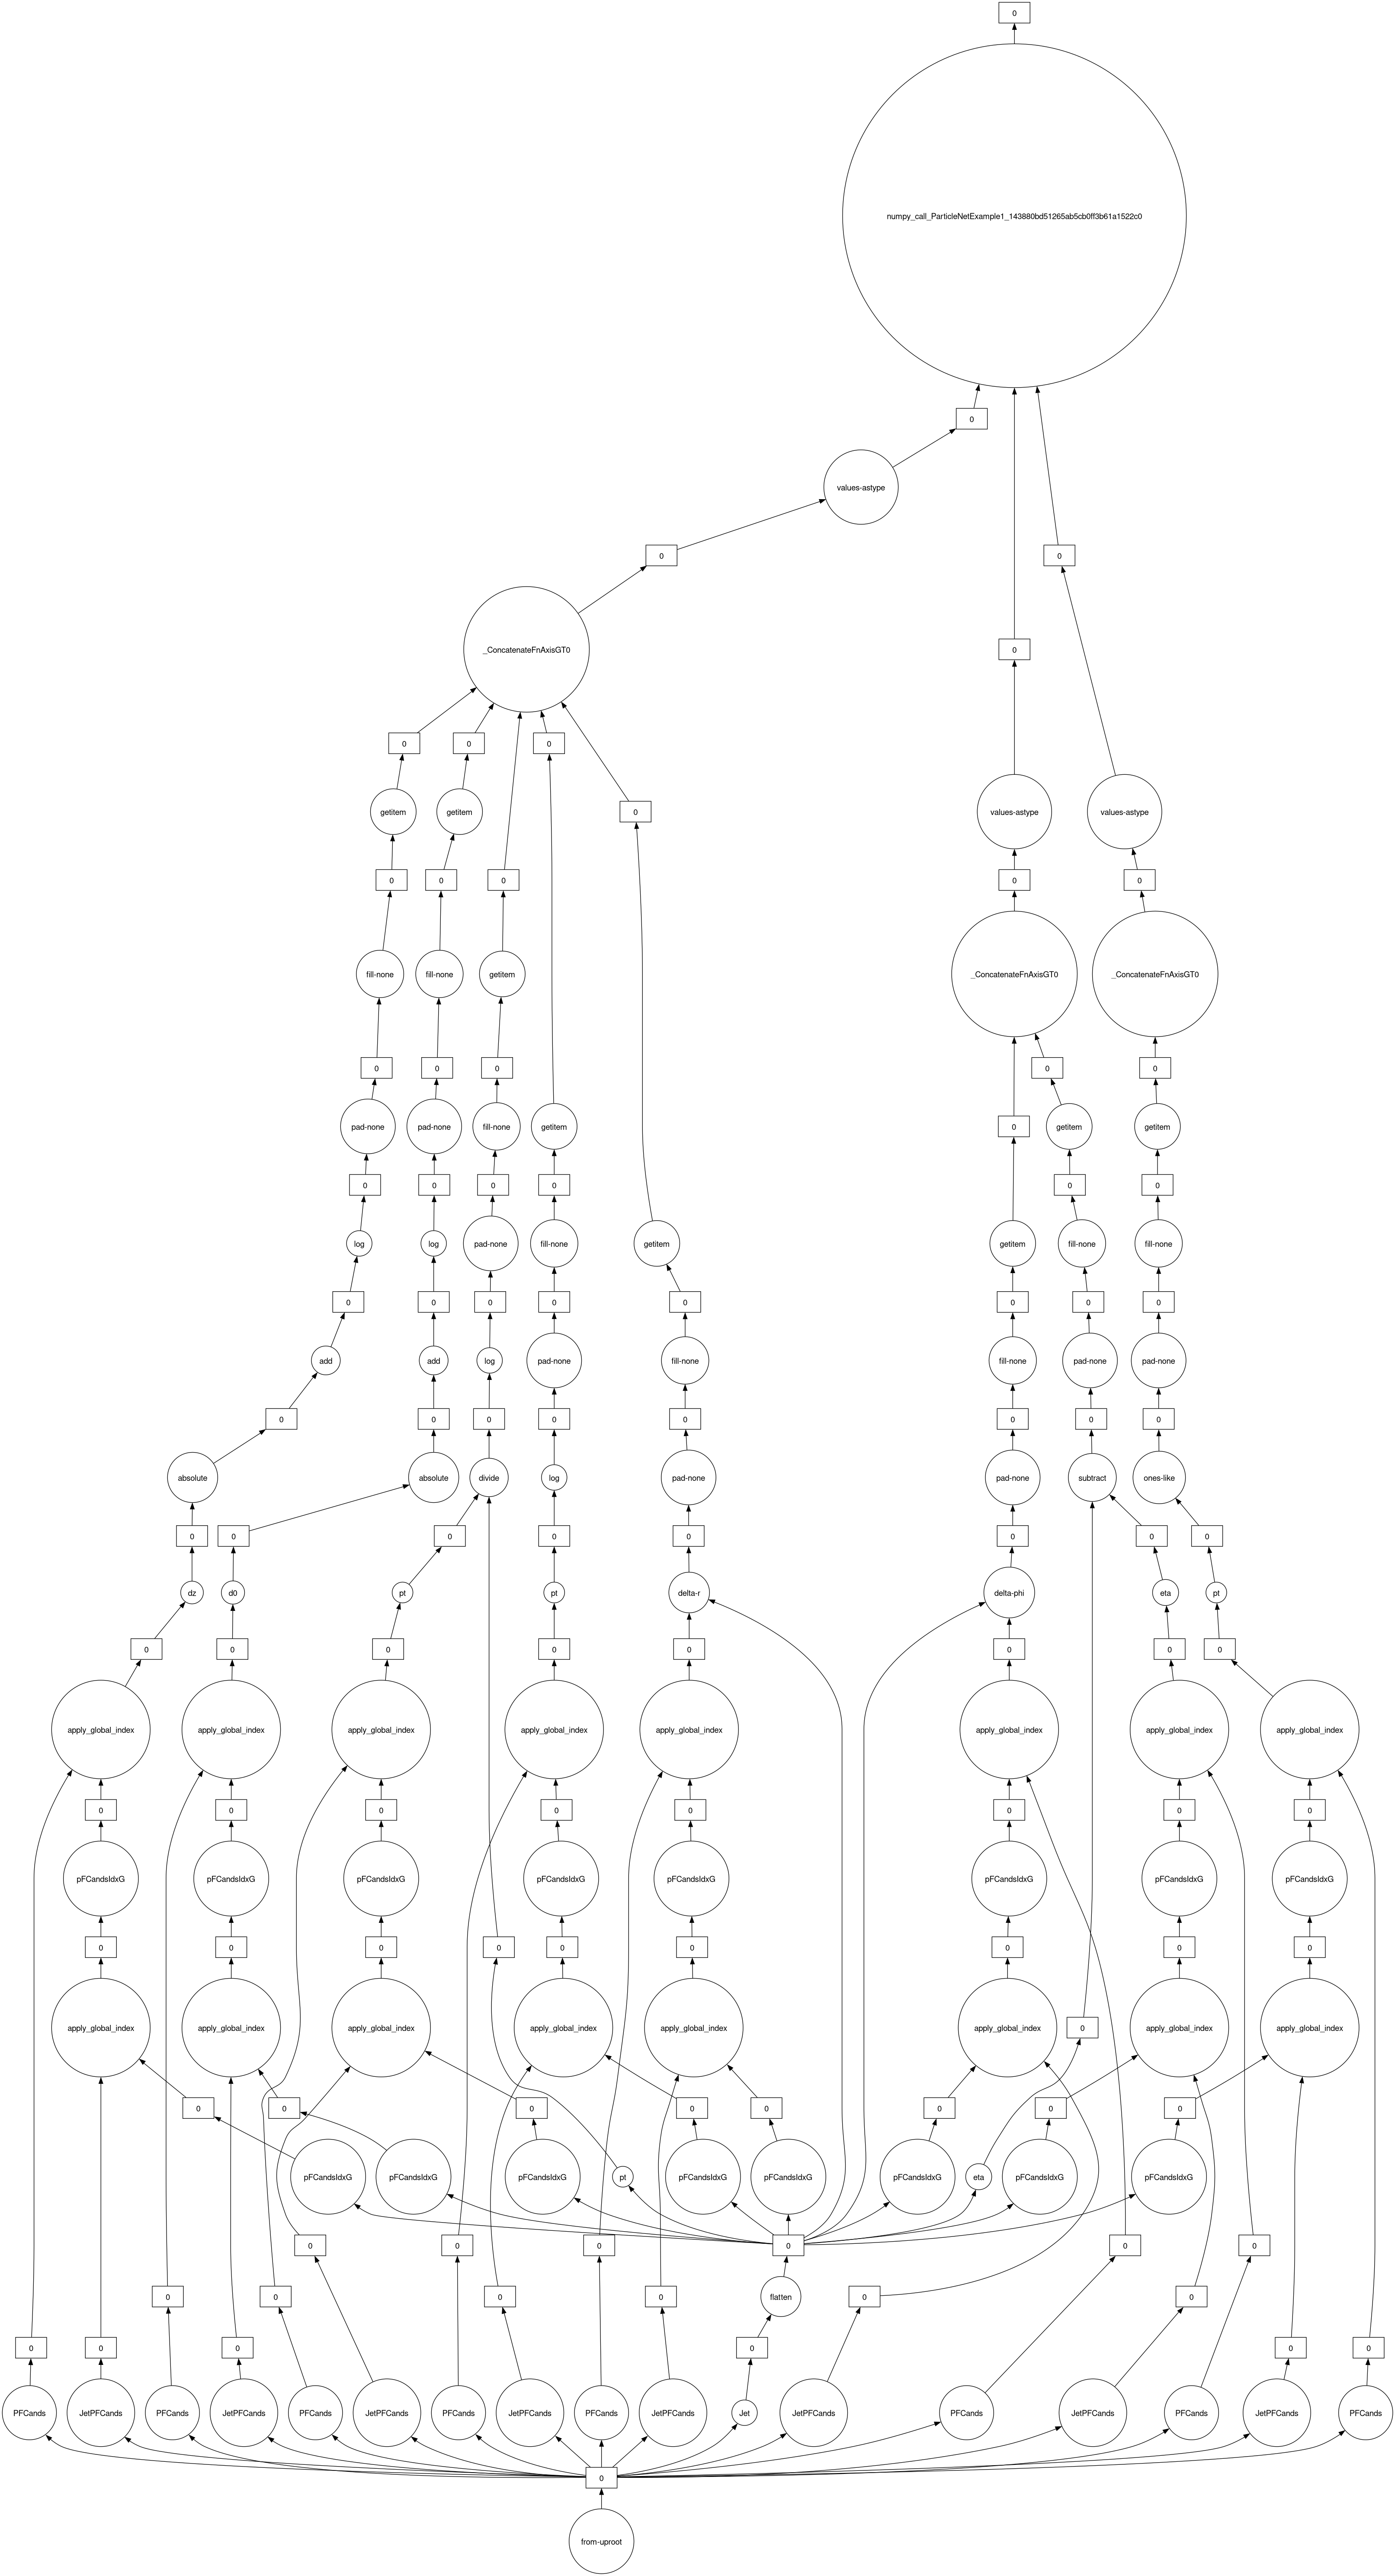

In [6]:
print(dask_results.dask)
dask_results.visualize(optimize_graph=False)


Or a peek at the optimized results:

/home/ensc/VirtualENV/coffea-test/lib/python3.8/site-packages/coffea/ml_tools/helper.py:163: UserWarning: No format checks were performed on input!
  warnings.warn("No format checks were performed on input!")


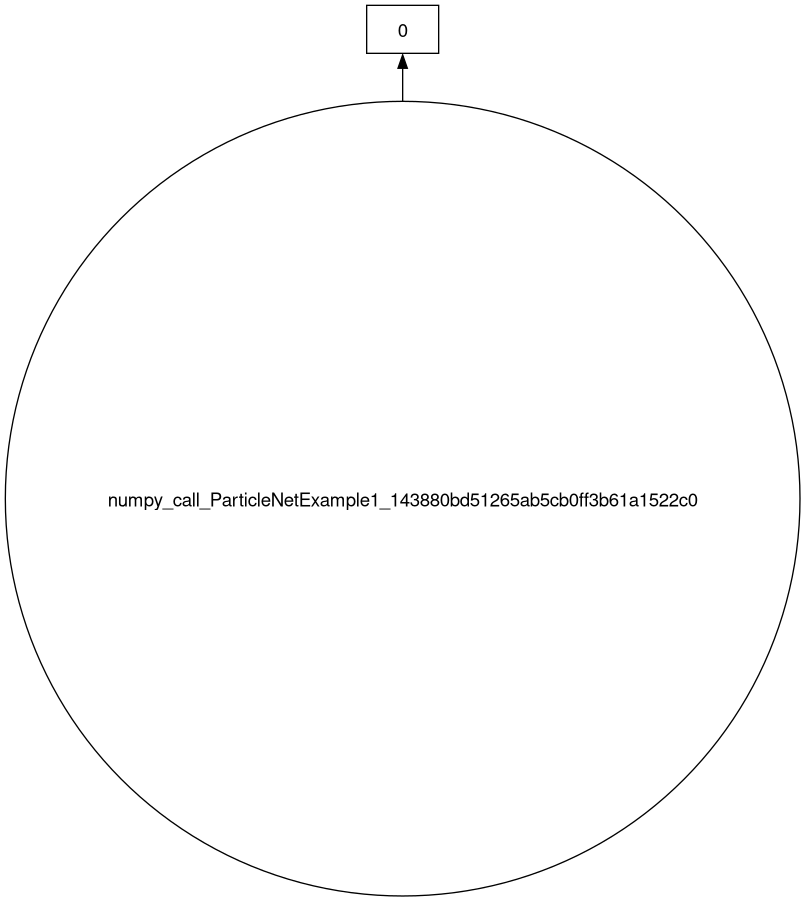

In [7]:
dask_results.visualize(optimize_graph=True)


## Comments about generalizing to other ML tools

All ML wrappers provided in the `coffea.mltools` module (`triton_wrapper` for
[triton][triton] server inference, `torch_wrapper` for pytorch, and
`xgboost_wrapper` for [xgboost][xgboost] inference) follow the same design:
analyzers is responsible for providing the model of interest, along with
providing an inherited class that overloads of the following methods to data
type conversion:

- `prepare_awkward`: converting awkward arrays to `numpy`-compatible awkward
  arrays, the output arrays should be in the format of a tuple `a` and a
  dictionary `b`, which can be expanded out to the input of the ML tool like
  `model(*a, **b)`. Notice some additional trivial conversion, such as the
  conversion to available kernels for `pytorch`, converting to a matrix format
  for `xgboost`, and slice of array for `triton` is handled automatically by the
  respective wrappers. To handle both dask/non-dask arrays, the user should use
  the provided `get_awkward_lib` library switcher.
- `postprocess_awkward` (optional): converting the trivial converted numpy array
  results back to the analysis specific format. If this is not provided, then a
  simple `ak.from_numpy` conversion results is returned.

If the ML tool of choice for your analysis has not been implemented by the
`coffea.mltools` modules, consider constructing your own with the provided
`numpy_call_wrapper` base class in `coffea.mltools`. Aside from the functions
listed above, you will also need to provide the `numpy_call` method to perform
any additional data format conversions, and call the ML tool of choice. If you
think your implementation is general, also consider submitting a PR to the
`coffea` repository!

[triton]: https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tritonserver
[xgboost]: https://xgboost.readthedocs.io/en/stable/
